In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,StackingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, confusion_matrix,
                           classification_report, roc_curve ,make_scorer)
from sklearn.calibration import CalibratedClassifierCV
import time
import joblib
import pickle
import warnings
warnings.filterwarnings('ignore')

   **DATA importation :**

In [6]:
def wrangle(datapath):
  df=pd.read_csv(datapath)
  return df

In [7]:
df=wrangle("PIMA_Processed.csv")
print(df.shape)
df.head()

(733, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.000000,14.849082,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.000000,14.569754,26.6,0.351,31.0,0
2,8.0,183.0,64.0,5.196022,14.928370,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.000000,94.000000,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.000000,168.000000,43.1,2.288,33.0,1


**Vertical split :**

In [8]:
X=df.drop("Outcome",axis=1)
y=df["Outcome"]
print(f"Features shape:{X.shape},Target shape:{y.shape}")

Features shape:(733, 8),Target shape:(733,)


**Horizontal split :**

In [9]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=7)
Scaler=StandardScaler()
X_train_scaled=Scaler.fit_transform(X_train)
X_test_scaled=Scaler.transform(X_test)
print(f"X_train shape:{X_train.shape},X_test shape:{X_test.shape}")
print(f"y_train shape:{y_train.shape},y_test shape:{y_test.shape}")

X_train shape:(586, 8),X_test shape:(147, 8)
y_train shape:(586,),y_test shape:(147,)


**BASELINE model :**

In [10]:
baseline_acc=y_train.value_counts(normalize=True).max()
print(f"Baseline accuracy:{baseline_acc}")

Baseline accuracy:0.6723549488054608


**Models Intialisation :**

In [11]:
def initialize_models():
  models = {
            'Logistic_Regression': LogisticRegression(random_state=42, max_iter=1000),
            'Random_Forest': RandomForestClassifier(random_state=42, n_estimators=100,n_jobs=-1),
            'SVM_RBF': SVC(random_state=42, probability=True, kernel='rbf'),
            'SVM_Linear': SVC(random_state=42, probability=True, kernel='linear'),
            'Decision_Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
            'Naive_Bayes': GaussianNB(),
            'KNN': KNeighborsClassifier(n_neighbors=5),
            'XGBoost': XGBClassifier(random_state=42, n_estimators=100)}
  print(f"Initialized {len(models)} models")
  return models


In [12]:
initialize_models()

Initialized 8 models


{'Logistic_Regression': LogisticRegression(max_iter=1000, random_state=42),
 'Random_Forest': RandomForestClassifier(n_jobs=-1, random_state=42),
 'SVM_RBF': SVC(probability=True, random_state=42),
 'SVM_Linear': SVC(kernel='linear', probability=True, random_state=42),
 'Decision_Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
 'Naive_Bayes': GaussianNB(),
 'KNN': KNeighborsClassifier(),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_

In [13]:
def Train_Evaluate_Models():

    metrics = ['Accuracy', 'Recall', 'Precision', 'F1_Score', 'ROC_AUC', 'Specificity']
    results = {metric: {} for metric in metrics}
    # results['CV_Scores'] = {}

    # skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    models = initialize_models()

    for model_name, model in models.items():
        if model_name in ['Logistic_Regression', 'SVM_RBF', 'SVM_Linear', 'KNN', 'Naive_Bayes']:
            X_train_use = X_train_scaled
            X_test_use = X_test_scaled
        else:
            X_train_use = X_train
            X_test_use = X_test

        model.fit(X_train_use, y_train)
        y_pred = model.predict(X_test_use)
        y_pred_proba = model.predict_proba(X_test_use)[:, 1]

        Accuracy = accuracy_score(y_test, y_pred)
        Recall = recall_score(y_test, y_pred)
        Precision = precision_score(y_test, y_pred)
        F1_Score = f1_score(y_test, y_pred)
        ROC_AUC = roc_auc_score(y_test, y_pred_proba)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).flatten()
        Specificity = tn / (tn + fp)

        # Cross_Val_Scores = cross_val_score(model, X_train_use, y_train, cv=skf, scoring='roc_auc')

        results['Accuracy'][model_name] = Accuracy
        results['Recall'][model_name] = Recall
        results['Precision'][model_name] = Precision
        results['F1_Score'][model_name] = F1_Score
        results['ROC_AUC'][model_name] = ROC_AUC
        results['Specificity'][model_name] = Specificity
        # results['CV_Scores'][model_name] = Cross_Val_Scores

    return results

In [14]:
Train_Evaluate_Models()

Initialized 8 models


{'Accuracy': {'Logistic_Regression': 0.8027210884353742,
  'Random_Forest': 0.7687074829931972,
  'SVM_RBF': 0.782312925170068,
  'SVM_Linear': 0.8027210884353742,
  'Decision_Tree': 0.6666666666666666,
  'Naive_Bayes': 0.7687074829931972,
  'KNN': 0.7278911564625851,
  'XGBoost': 0.7346938775510204},
 'Recall': {'Logistic_Regression': 0.5892857142857143,
  'Random_Forest': 0.5357142857142857,
  'SVM_RBF': 0.5714285714285714,
  'SVM_Linear': 0.5892857142857143,
  'Decision_Tree': 0.5178571428571429,
  'Naive_Bayes': 0.6071428571428571,
  'KNN': 0.5178571428571429,
  'XGBoost': 0.6071428571428571},
 'Precision': {'Logistic_Regression': 0.8461538461538461,
  'Random_Forest': 0.7894736842105263,
  'SVM_RBF': 0.8,
  'SVM_Linear': 0.8461538461538461,
  'Decision_Tree': 0.5686274509803921,
  'Naive_Bayes': 0.7391304347826086,
  'KNN': 0.6904761904761905,
  'XGBoost': 0.6666666666666666},
 'F1_Score': {'Logistic_Regression': 0.6947368421052632,
  'Random_Forest': 0.6382978723404256,
  'SVM_RB

In [15]:
def Metrics_into_DF():
  results=Train_Evaluate_Models()
  models=initialize_models()
  metrics=['Accuracy', 'Recall', 'Precision', 'F1_Score', 'ROC_AUC', 'Specificity']
  df_results=pd.DataFrame(results,index=models.keys())
  df_results=df_results.T
  # df_results=df_results.sort_values()
  return df_results

In [16]:
Metrics_into_DF()

Initialized 8 models
Initialized 8 models


,Logistic_Regression,Random_Forest,SVM_RBF,SVM_Linear,Decision_Tree,Naive_Bayes,KNN,XGBoost
Accuracy,0.802721,0.768707,0.782313,0.802721,0.666667,0.768707,0.727891,0.734694
Recall,0.589286,0.535714,0.571429,0.589286,0.517857,0.607143,0.517857,0.607143
Precision,0.846154,0.789474,0.800000,0.846154,0.568627,0.739130,0.690476,0.666667
F1_Score,0.694737,0.638298,0.666667,0.694737,0.542056,0.666667,0.591837,0.635514
ROC_AUC,0.841641,0.854297,0.842818,0.838501,0.650805,0.833006,0.778748,0.804749
Specificity,0.934066,0.912088,0.912088,0.934066,0.758242,0.868132,0.857143,0.813187


In [17]:
def Confusion_Matrixes():
  models=initialize_models()
  for model_name,model in models.items():
    model.fit(X_train_scaled,y_train)
    y_pred=model.predict(X_test_scaled)
    cm=confusion_matrix(y_test,y_pred)
    sns.heatmap(cm,annot=True,cmap="Blues",fmt="d")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

Initialized 8 models


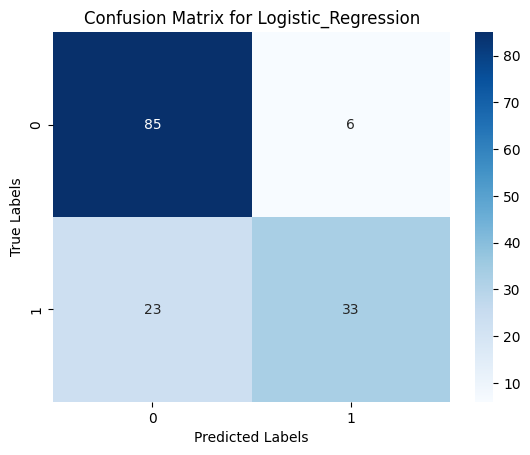

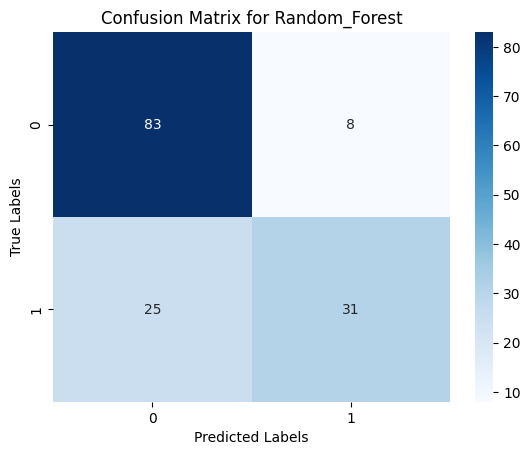

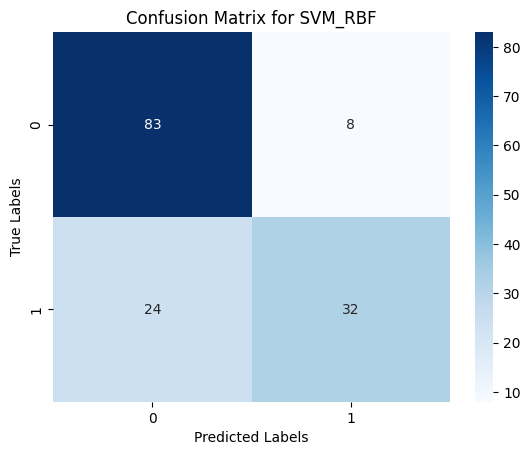

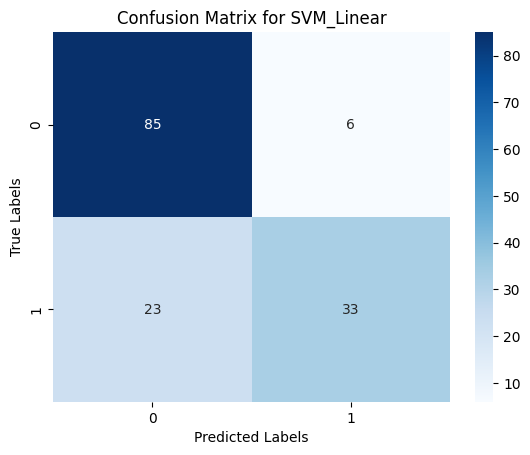

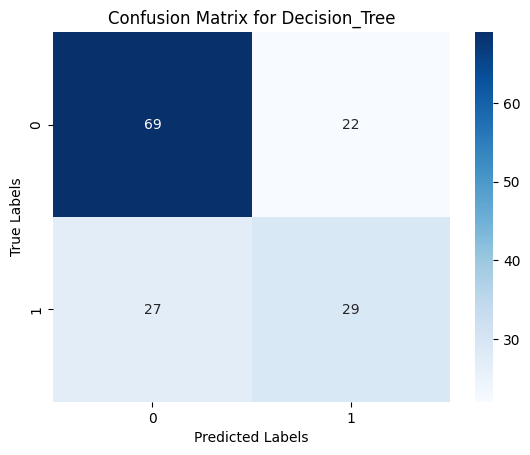

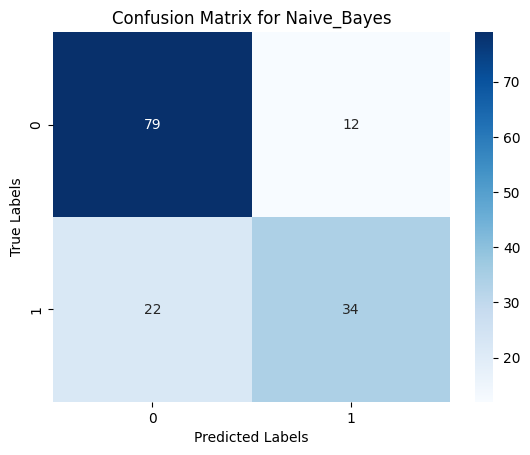

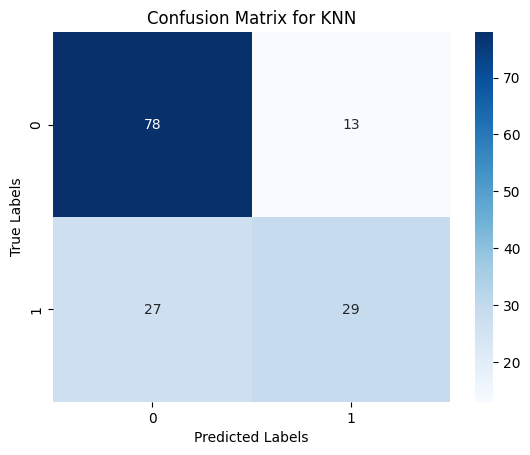

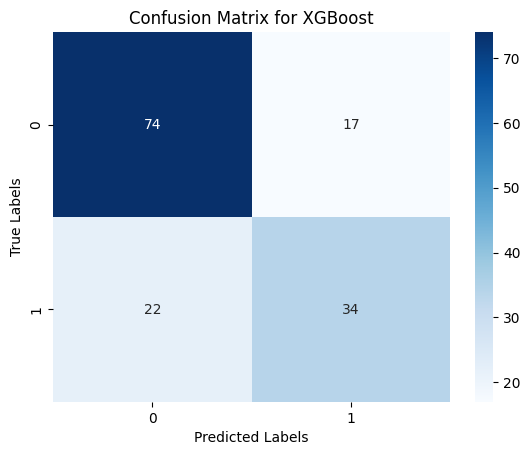

In [18]:
Confusion_Matrixes()

In [19]:
def Fine_tune_models():
    models = initialize_models()
    NB = models['Naive_Bayes']
    LR = models['Logistic_Regression']
    RF = models['Random_Forest']
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    tuning_results = {}
    best_models = {}


    # Naive_Bayes:
    print("\n🔧 Tuning Naive Bayes...")
    NB_params = {'var_smoothing': [1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}
    NB_grid = GridSearchCV(
        GaussianNB(),
        param_grid=NB_params,
        cv=cv_strategy,
        scoring='recall',
        n_jobs=-1,
        verbose=1
    )
    NB_grid.fit(X_train_scaled, y_train)
    best_models['Naive_Bayes'] = NB_grid.best_estimator_
    tuning_results['Naive_Bayes'] = NB_grid.best_score_
    print(f"Best params: {NB_grid.best_params_}")
    print(f" Best CV recall: {NB_grid.best_score_:.4f}")

    # Random_Forest:
    print("\n🔧 Tuning Random Forest...")
    RF_params = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, 15, 20, None],
        'class_weight': [None, 'balanced']
    }
    RF_grid = GridSearchCV(
        RandomForestClassifier(random_state=7, n_jobs=-1),
        param_grid=RF_params,
        cv=cv_strategy,
        scoring='recall',
        n_jobs=-1,
        verbose=1
    )

    RF_grid.fit(X_train, y_train)
    best_models['Random_Forest'] = RF_grid.best_estimator_
    tuning_results['Random_Forest'] = RF_grid.best_score_
    print(f"Best params: {RF_grid.best_params_}")
    print(f" Best CV recall: {RF_grid.best_score_:.4f}")

    # Logistic_Regression:
    print("\n🔧 Tuning Logistic Regression...")
    LR_params = {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['lbfgs'],
        'class_weight': [None, 'balanced']
    }
    LR_grid = GridSearchCV(
        LogisticRegression(random_state=7, max_iter=1000),
        param_grid=LR_params,
        cv=cv_strategy,
        scoring='recall',
        n_jobs=-1,
        verbose=1
    )
    LR_grid.fit(X_train_scaled, y_train)
    best_models['Logistic_Regression'] = LR_grid.best_estimator_
    tuning_results['Logistic_Regression'] = LR_grid.best_score_
    print(f" Best params: {LR_grid.best_params_}")
    print(f" Best CV recall: {LR_grid.best_score_:.4f}")

    print("\n🎉 Fine-tuning completed!")
    return tuning_results, best_models

In [20]:
Fine_tune_models()

Initialized 8 models

🔧 Tuning Naive Bayes...
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best params: {'var_smoothing': 1e-11}
 Best CV recall: 0.5730

🔧 Tuning Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'class_weight': 'balanced', 'max_depth': 5, 'n_estimators': 200}
 Best CV recall: 0.6981

🔧 Tuning Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Best params: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
 Best CV recall: 0.7139

🎉 Fine-tuning completed!


({'Naive_Bayes': np.float64(0.5730094466936573),
  'Random_Forest': np.float64(0.698110661268556),
  'Logistic_Regression': np.float64(0.7139001349527665)},
 {'Naive_Bayes': GaussianNB(var_smoothing=1e-11),
  'Random_Forest': RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=200,
                         n_jobs=-1, random_state=7),
  'Logistic_Regression': LogisticRegression(C=10, class_weight='balanced', max_iter=1000, random_state=7)})

In [21]:
def evaluate_tuned_models(best_models):
    tuned_results={}
    for model_name, model in best_models.items():
      if model_name in ['Logistic_Regression','Naive_Bayes']:
        X_Train_to_use=X_train_scaled
        X_Test_to_use=X_test_scaled
      else:
        X_to_use=X_train
      model.fit(X_Train_to_use,y_train)
      y_pred=model.predict(X_Test_to_use)
      y_proba=model.predict_proba(X_Test_to_use)[:,1]

      #metrics:
      Accuracy=accuracy_score(y_test,y_pred)
      Recall=recall_score(y_test,y_pred)
      Precision=precision_score(y_test,y_pred)
      F1_Score=f1_score(y_test,y_pred)
      ROC_AUC=roc_auc_score(y_test,y_proba)
      tn,fp,fn,tp=confusion_matrix(y_test,y_pred).flatten()
      Specificity=tn/(tn+fp)

      #Storing Metrics:
      tuned_results[model_name]={}
      tuned_results[model_name]["Accuracy"]=Accuracy
      tuned_results[model_name]["Recall"]=Recall
      tuned_results[model_name]["Precision"]=Precision
      tuned_results[model_name]["F1_Score"]=F1_Score
      tuned_results[model_name]["ROC_AUC"]=ROC_AUC
      tuned_results[model_name]["Specificity"]=Specificity
    return tuned_results




In [22]:
tuned_results,best_models=Fine_tune_models()
evaluate_tuned_models(best_models)

Initialized 8 models

🔧 Tuning Naive Bayes...
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best params: {'var_smoothing': 1e-11}
 Best CV recall: 0.5730

🔧 Tuning Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'class_weight': 'balanced', 'max_depth': 5, 'n_estimators': 200}
 Best CV recall: 0.6981

🔧 Tuning Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Best params: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
 Best CV recall: 0.7139

🎉 Fine-tuning completed!


{'Naive_Bayes': {'Accuracy': 0.7687074829931972,
  'Recall': 0.6071428571428571,
  'Precision': 0.7391304347826086,
  'F1_Score': 0.6666666666666666,
  'ROC_AUC': np.float64(0.8330062794348508),
  'Specificity': np.float64(0.8681318681318682)},
 'Random_Forest': {'Accuracy': 0.7619047619047619,
  'Recall': 0.7142857142857143,
  'Precision': 0.6779661016949152,
  'F1_Score': 0.6956521739130435,
  'ROC_AUC': np.float64(0.8522370486656201),
  'Specificity': np.float64(0.7912087912087912)},
 'Logistic_Regression': {'Accuracy': 0.7414965986394558,
  'Recall': 0.7142857142857143,
  'Precision': 0.6451612903225806,
  'F1_Score': 0.6779661016949152,
  'ROC_AUC': np.float64(0.8422291993720564),
  'Specificity': np.float64(0.7582417582417582)}}

In [23]:
def Metrics_into_DF1():
  tuned_results,best_models=Fine_tune_models()
  results=evaluate_tuned_models(best_models)
  metrics=['Accuracy', 'Recall', 'Precision', 'F1_Score', 'ROC_AUC', 'Specificity']
  df_results=pd.DataFrame(results)
  df_results=df_results.T
  # df_results=df_results.sort_values()
  return df_results

In [24]:
Metrics_into_DF1()

Initialized 8 models

🔧 Tuning Naive Bayes...
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best params: {'var_smoothing': 1e-11}
 Best CV recall: 0.5730

🔧 Tuning Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'class_weight': 'balanced', 'max_depth': 5, 'n_estimators': 200}
 Best CV recall: 0.6981

🔧 Tuning Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Best params: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
 Best CV recall: 0.7139

🎉 Fine-tuning completed!


,Accuracy,Recall,Precision,F1_Score,ROC_AUC,Specificity
Naive_Bayes,0.768707,0.607143,0.739130,0.666667,0.833006,0.868132
Random_Forest,0.761905,0.714286,0.677966,0.695652,0.852237,0.791209
Logistic_Regression,0.741497,0.714286,0.645161,0.677966,0.842229,0.758242


In [25]:
def Ensambe_aproch(best_models):
  NB=best_models['Naive_Bayes']
  LR=best_models['Logistic_Regression']
  RF=best_models['Random_Forest']
  #Calibrate Naive Bayes:
  NB_Calibrated=CalibratedClassifierCV(NB,cv=5,method='isotonic')
  NB_Calibrated.fit(X_train_scaled,y_train)

  #Building an Ensamble model:
  Estimators=[("Naive_Bayes",NB_Calibrated),
      ("Logistic_Regression",LR),
      ("Random_Forest",RF)]

  Meta_learner=LogisticRegression(C=10, class_weight='balanced', max_iter=1000, random_state=7,solver='lbfgs',penalty='l2')

  Stacked_model=StackingClassifier(
      estimators=Estimators,
      final_estimator=Meta_learner,
      stack_method='predict_proba',
      cv=5,
      n_jobs=-1,
      verbose=1
  )
  Stacked_model.fit(X_train_scaled,y_train)
  return Stacked_model



In [37]:
tuned_results,best_models=Fine_tune_models()
Stacked_model=Ensambe_aproch(best_models)

Initialized 8 models

🔧 Tuning Naive Bayes...
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best params: {'var_smoothing': 1e-11}
 Best CV recall: 0.5730

🔧 Tuning Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'class_weight': 'balanced', 'max_depth': 5, 'n_estimators': 200}
 Best CV recall: 0.6981

🔧 Tuning Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Best params: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
 Best CV recall: 0.7139

🎉 Fine-tuning completed!


In [38]:
def Evaluate_Stacked_model(stacked_model):
  Stacked_results={}
  # stacked_model=Ensambe_aproch(best_models)
  y_pred=stacked_model.predict(X_test_scaled)
  y_proba=stacked_model.predict_proba(X_test_scaled)[:,1]
  Accuracy=accuracy_score(y_test,y_pred)
  Recall=recall_score(y_test,y_pred)
  Precision=precision_score(y_test,y_pred)
  F1_Score=f1_score(y_test,y_pred)
  ROC_AUC=roc_auc_score(y_test,y_proba)
  tn,fp,fn,tp=confusion_matrix(y_test,y_pred).flatten()
  Specificity=tn/(tn+fp)
  Stacked_results["Accuracy"]=Accuracy
  Stacked_results["Recall"]=Recall
  Stacked_results["Precision"]=Precision
  Stacked_results["F1_Score"]=F1_Score
  Stacked_results["ROC_AUC"]=ROC_AUC
  Stacked_results["Specificity"]=Specificity
  return Stacked_results




In [39]:
Evaluate_Stacked_model(Stacked_model)

{'Accuracy': 0.782312925170068,
 'Recall': 0.8035714285714286,
 'Precision': 0.6818181818181818,
 'F1_Score': 0.7377049180327869,
 'ROC_AUC': np.float64(0.8624411302982732),
 'Specificity': np.float64(0.7692307692307693)}

In [40]:
def Confsion_matrix():
  Stacked_model=Ensambe_aproch(best_models)
  y_pred=Stacked_model.predict(X_test_scaled)
  cm=confusion_matrix(y_test,y_pred)
  sns.heatmap(cm,annot=True,cmap="Blues",fmt="d")
  plt.title(f"Confusion Matrix for Ensambled Model")
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.show()

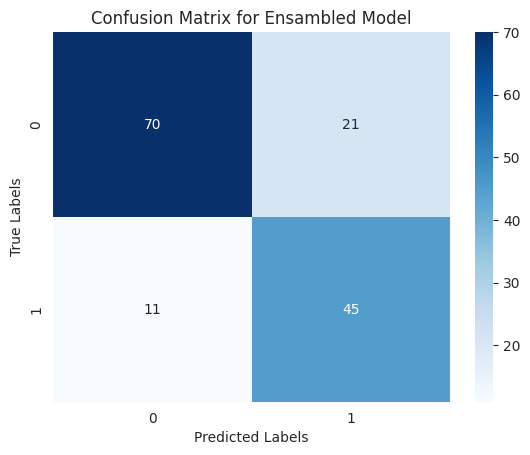

In [41]:
Confsion_matrix()

In [43]:
df_stacked=pd.DataFrame(Evaluate_Stacked_model(Stacked_model),index=["Stacked_Model"])
df_stacked

,Accuracy,Recall,Precision,F1_Score,ROC_AUC,Specificity
Stacked_Model,0.782313,0.803571,0.681818,0.737705,0.862441,0.769231


In [44]:
df_performance=pd.concat([Metrics_into_DF1(),df_stacked])
df_performance

Initialized 8 models

🔧 Tuning Naive Bayes...
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best params: {'var_smoothing': 1e-11}
 Best CV recall: 0.5730

🔧 Tuning Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'class_weight': 'balanced', 'max_depth': 5, 'n_estimators': 200}
 Best CV recall: 0.6981

🔧 Tuning Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Best params: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
 Best CV recall: 0.7139

🎉 Fine-tuning completed!


,Accuracy,Recall,Precision,F1_Score,ROC_AUC,Specificity
Naive_Bayes,0.768707,0.607143,0.739130,0.666667,0.833006,0.868132
Random_Forest,0.761905,0.714286,0.677966,0.695652,0.852237,0.791209
Logistic_Regression,0.741497,0.714286,0.645161,0.677966,0.842229,0.758242
Stacked_Model,0.782313,0.803571,0.681818,0.737705,0.862441,0.769231


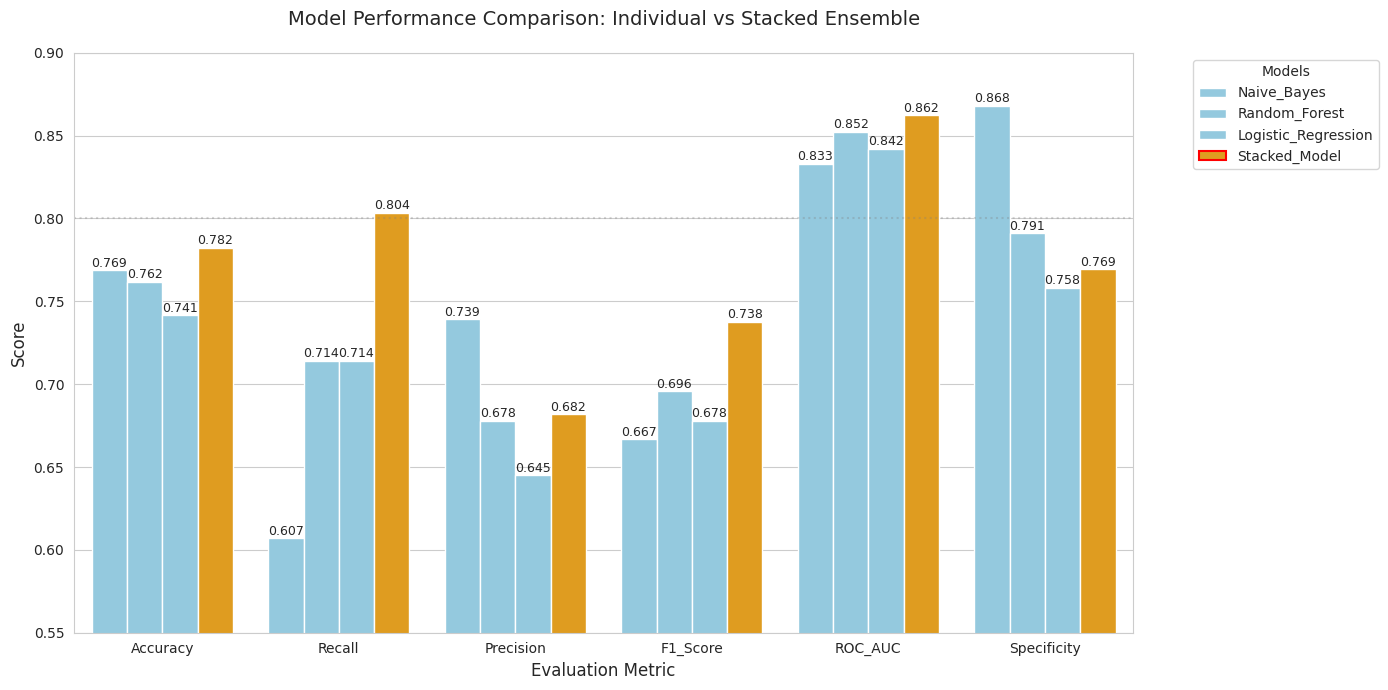

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming df_performance is your current DataFrame
# If needed, convert index to column
df = df_performance.reset_index().rename(columns={'index': 'Model'})

# Melt the dataframe for seaborn
df_melted = df.melt(id_vars='Model',
                    value_vars=['Accuracy', 'Recall', 'Precision', 'F1_Score', 'ROC_AUC', 'Specificity'],
                    var_name='Metric',
                    value_name='Value')

# Create a custom palette
palette = {model: 'orange' if 'Stacked' in model else 'skyblue' for model in df['Model']}

# Create plot
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

# Create grouped barplot
ax = sns.barplot(
    x="Metric",
    y="Value",
    hue="Model",
    data=df_melted,
    palette=palette,
    errorbar=None,
    dodge=True
)

# Customize plot
plt.title('Model Performance Comparison: Individual vs Stacked Ensemble', pad=20, fontsize=14)
plt.ylim(0.55, 0.9)  # Adjusted to your metrics range
plt.ylabel('Score', fontsize=12)
plt.xlabel('Evaluation Metric', fontsize=12)

# Add value labels
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.3f}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', xytext=(0, 5), textcoords='offset points',
        fontsize=9
    )

# Highlight the stacked model
for i, p in enumerate(ax.patches):
    if 'Stacked' in p.get_label():
        p.set_edgecolor('red')
        p.set_linewidth(1.5)

# Move legend and adjust layout
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Models')
plt.tight_layout()

# Add horizontal line at 0.8 for reference
ax.axhline(y=0.8, color='gray', linestyle=':', alpha=0.3)

plt.show()

Text(0, 0.5, 'Features')

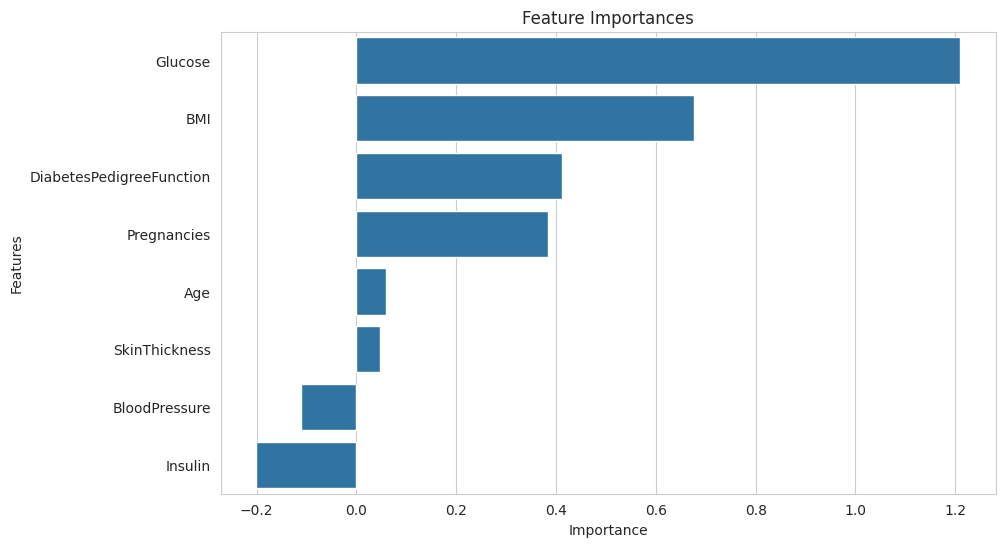

In [46]:
LR=best_models['Logistic_Regression']
features=X.columns
Importances=LR.coef_[0]
feat_impotrances=pd.Series(Importances,index=features).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_impotrances,y=feat_impotrances.index)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Features")

In [58]:
with open("Diabities_model.pkl","wb") as f:
  pickle.dump(Stacked_model,f)
  joblib.dump(Stacked_model,"best_models.pkl")
  joblib.dump(Scaler, 'Diabetes_scaler.pkl')


In [57]:
def predict_diabetes(Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age):
  model=joblib.load("Diabities_model.pkl")
  scaler=joblib.load("Diabetes_scaler.pkl")
  input_data=np.array([[Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age]])
  input_data_scaled=scaler.transform(input_data)
  prediction=model.predict(input_data_scaled)
  return prediction[0]



In [56]:
input_data=np.array([[6,146,72,35,0,33.6,0.627,50]])
prediction=Stacked_model.predict(input_data)
prediction

array([1])